# Table Extraction with OpenCV

This notebook demonstrates a pipeline for extracting tables from document images using OpenCV. The process involves:

1. Image preprocessing and enhancement
2. Deskewing (correcting image rotation)
3. Table structure detection (horizontal and vertical lines)
4. Cell detection and extraction
5. OCR processing

In [3]:
import cv2
import numpy as np
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt

In [4]:
img_path = "samples/XNDH.png"
original_img = cv2.imread(img_path)

In [5]:
def preprocess(img, factor: int):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = Image.fromarray(img)
    enhancer = ImageEnhance.Sharpness(img).enhance(factor)
    if gray.std() < 30:
        enhancer = ImageEnhance.Contrast(enhancer).enhance(factor)
    return np.array(enhancer)


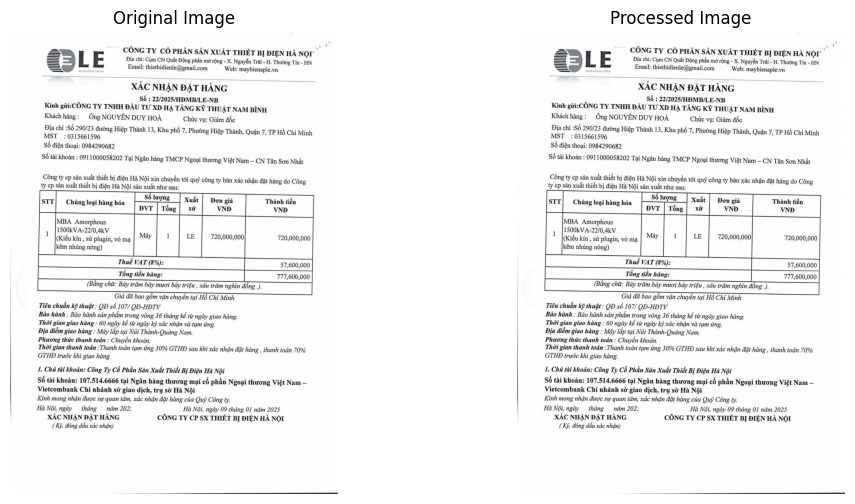

In [6]:
processed_img = preprocess(original_img, 2)

original_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
processed_rgb = cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB)

# Hiển thị bằng matplotlib
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_rgb)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Processed Image")
plt.imshow(processed_rgb)
plt.axis("off")

plt.show()

In [11]:
def deskew_by_hough(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)

    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)
    if lines is None:
        print("No lines found.")
        return img

    angles = []
    for rho, theta in lines[:, 0]:
        angle = (theta * 180 / np.pi) - 90
        # Chỉ lấy các góc gần ngang (nghiêng nhẹ)
        if -45 < angle < 45:
            angles.append(angle)

    if not angles:
        print("No valid angles found.")
        return img

    median_angle = np.median(angles)
    print(f"[+] Hough-detected skew angle: {median_angle:.2f} degrees")

    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, median_angle, 1.0)
    rotated = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    return rotated

In [8]:
def deskew_by_min_area_rect(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply thresholding to make it binary
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    # Find all contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter out small contours (noise)
    contours = [c for c in contours if cv2.contourArea(c) > 100]
    
    # Get the largest contour (likely the page/document)
    if not contours:
        print("No contours found.")
        return img
        
    # Combine all contours into one for better angle detection
    all_points = np.concatenate(contours)
    
    # Find rotated rectangle
    rect = cv2.minAreaRect(all_points)
    angle = rect[2]
    
    # OpenCV returns angle in range (-90, 0] for clockwise rotation
    # We need to adjust it to get the correct skew angle
    if angle < -45:
        angle = 90 + angle
    
    print(f"[+] MinAreaRect-detected skew angle: {angle:.2f} degrees")
    
    # Rotate the image to deskew
    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    
    return rotated

In [9]:
deskewed_img = deskew_by_min_area_rect(processed_img)

[+] MinAreaRect-detected skew angle: -0.00 degrees


[+] Hough-detected skew angle: -1.00 degrees
[+] MinAreaRect-detected skew angle: -0.00 degrees


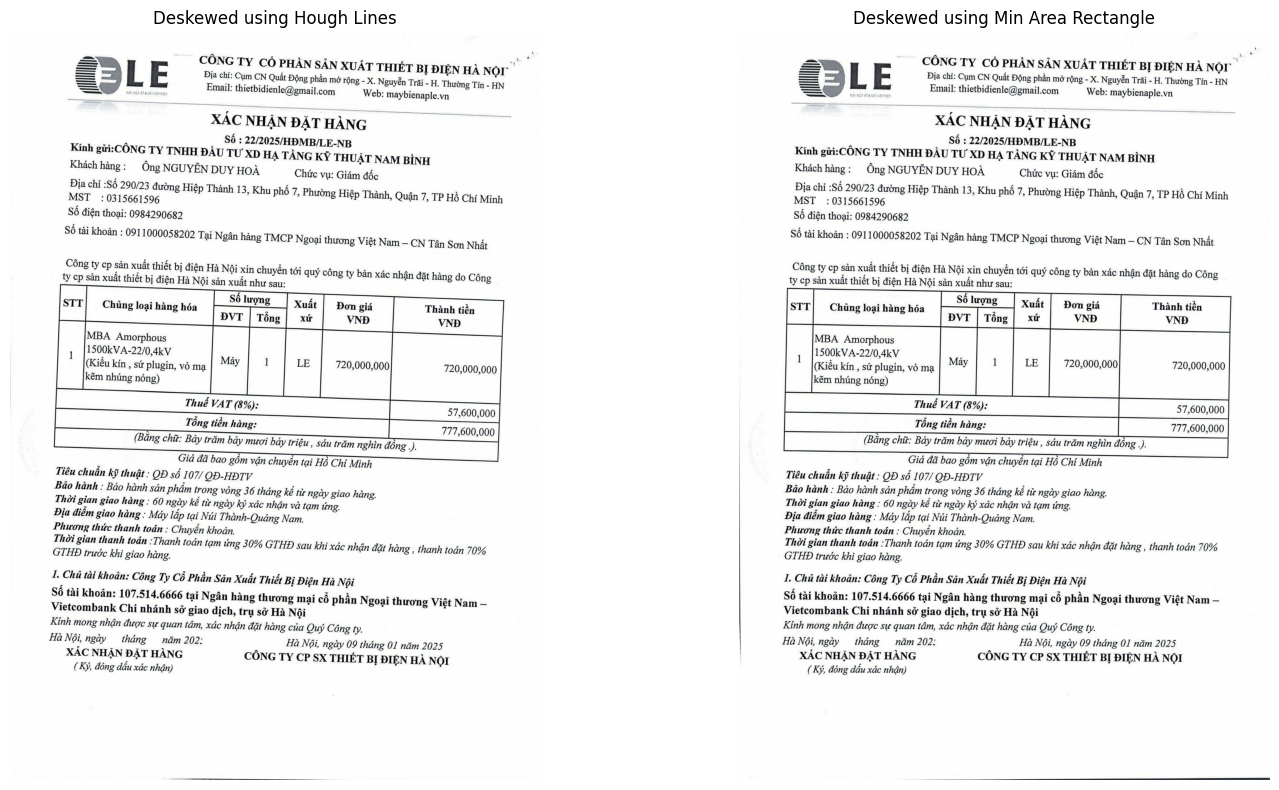

In [12]:
# Let's try both deskewing methods and compare them
deskewed_hough = deskew_by_hough(processed_img)
deskewed_min_area = deskew_by_min_area_rect(processed_img)

# Choose the better one (by default use min_area_rect method as it's usually more reliable)
deskewed_img = deskewed_min_area

# Display both for comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].imshow(cv2.cvtColor(deskewed_hough, cv2.COLOR_BGR2RGB))
axes[0].set_title("Deskewed using Hough Lines")
axes[0].axis("off")

axes[1].imshow(cv2.cvtColor(deskewed_min_area, cv2.COLOR_BGR2RGB))
axes[1].set_title("Deskewed using Min Area Rectangle")
axes[1].axis("off")

plt.tight_layout()
plt.show()

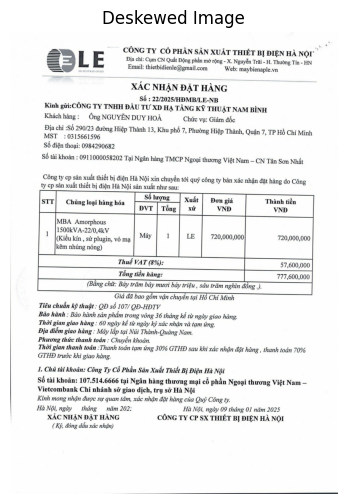

In [13]:
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(deskewed_img, cv2.COLOR_BGR2RGB))
plt.title("Deskewed Image")
plt.axis("off")
plt.show()

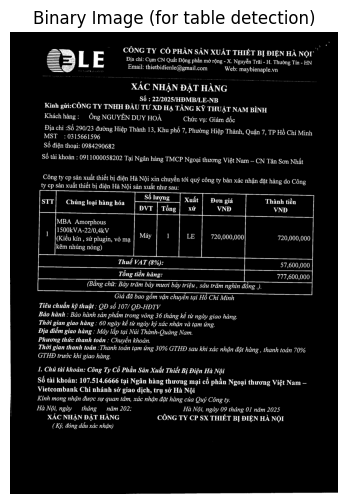

In [14]:
gray = cv2.cvtColor(processed_img, cv2.COLOR_BGR2GRAY)
thresh, img_bin = cv2.threshold(
    gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU
)
img_bin = 255 - img_bin  # Đảo màu: nền trắng, chữ đen

plt.figure(figsize=(8, 6))
plt.imshow(img_bin, cmap='gray')
plt.title("Binary Image (for table detection)")
plt.axis("off")
plt.show()

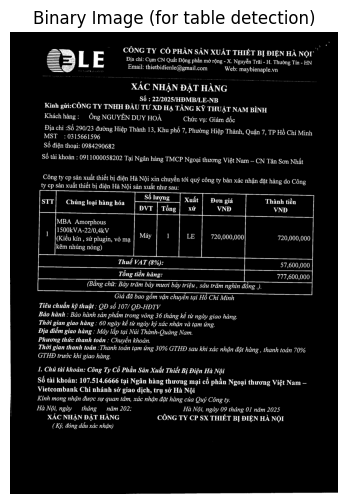

In [15]:
# Use the deskewed image for further processing
gray = cv2.cvtColor(deskewed_img, cv2.COLOR_BGR2GRAY)
thresh, img_bin = cv2.threshold(
    gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU
)
img_bin = 255 - img_bin  # Đảo màu: nền trắng, chữ đen

plt.figure(figsize=(8, 6))
plt.imshow(img_bin, cmap='gray')
plt.title("Binary Image (for table detection)")
plt.axis("off")
plt.show()

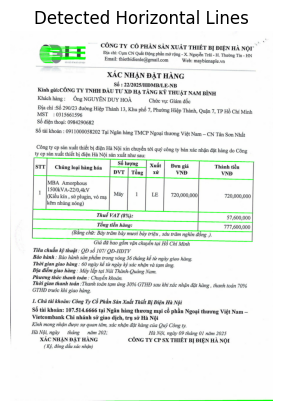

In [16]:
kernel_len = gray.shape[1] // 120  # độ dài kernel theo chiều ngang
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
# Làm mảnh đường trước
image_horizontal = cv2.erode(img_bin, hor_kernel, iterations=3)
# Làm dày lại sau
horizontal_lines = cv2.dilate(image_horizontal, hor_kernel, iterations=3)
h_lines = cv2.HoughLinesP(horizontal_lines, 1, np.pi/180, 30, maxLineGap=250)

# Vẽ đường
line_img = processed_img.copy()
if h_lines is not None:
    for line in h_lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(line_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Hiển thị
plt.imshow(cv2.cvtColor(line_img, cv2.COLOR_BGR2RGB))
plt.title("Detected Horizontal Lines")
plt.axis("off")
plt.show()

In [17]:
def group_h_lines(h_lines, thin_thresh):
    new_h_lines = []
    while len(h_lines) > 0:
        thresh = sorted(h_lines, key=lambda x: x[0][1])[0][0]
        lines = [line for line in h_lines if thresh[1] -
                 thin_thresh <= line[0][1] <= thresh[1] + thin_thresh]
        h_lines = [line for line in h_lines if thresh[1] - thin_thresh >
                   line[0][1] or line[0][1] > thresh[1] + thin_thresh]
        x = []
        for line in lines:
            x.append(line[0][0])
            x.append(line[0][2])
        x_min, x_max = min(x) - int(5*thin_thresh), max(x) + int(5*thin_thresh)
        new_h_lines.append([x_min, thresh[1], x_max, thresh[1]])
    return new_h_lines
    
new_horizontal_lines = group_h_lines(h_lines, kernel_len)


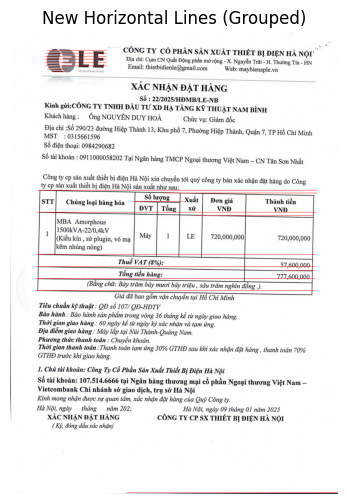

In [19]:
def group_h_lines(h_lines, thin_thresh):
    new_h_lines = []
    while len(h_lines) > 0:
        thresh = sorted(h_lines, key=lambda x: x[0][1])[0][0]
        lines = [line for line in h_lines if thresh[1] -
                 thin_thresh <= line[0][1] <= thresh[1] + thin_thresh]
        h_lines = [line for line in h_lines if thresh[1] - thin_thresh >
                   line[0][1] or line[0][1] > thresh[1] + thin_thresh]
        x = []
        for line in lines:
            x.append(line[0][0])
            x.append(line[0][2])
        # Adjust the padding factor to be smaller (from 5 to 2)
        x_min, x_max = min(x) - int(thin_thresh), max(x) + int(thin_thresh)
        new_h_lines.append([x_min, thresh[1], x_max, thresh[1]])
    return new_h_lines
    
new_horizontal_lines = group_h_lines(h_lines, kernel_len)

# Vẽ các dòng ngang đã gom nhóm
img_lines = processed_img.copy()

for line in new_horizontal_lines:
    x1, y1, x2, y2 = line
    cv2.line(img_lines, (x1, y1), (x2, y2), (0, 0, 255), 2)

plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(img_lines, cv2.COLOR_BGR2RGB))
plt.title("New Horizontal Lines (Grouped)")
plt.axis("off")
plt.show()

In [20]:
kernel_len = gray.shape[1]//120
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
image_vertical = cv2.erode(img_bin, ver_kernel, iterations=3)
vertical_lines = cv2.dilate(image_vertical, ver_kernel, iterations=3)

v_lines = cv2.HoughLinesP(vertical_lines, 1, np.pi/180, 30, maxLineGap=250)

In [21]:
def group_v_lines(v_lines, thin_thresh):
    new_v_lines = []
    while len(v_lines) > 0:
        thresh = sorted(v_lines, key=lambda x: x[0][0])[0][0]
        lines = [line for line in v_lines if thresh[0] -
                 thin_thresh <= line[0][0] <= thresh[0] + thin_thresh]
        v_lines = [line for line in v_lines if thresh[0] - thin_thresh >
                   line[0][0] or line[0][0] > thresh[0] + thin_thresh]
        y = []
        for line in lines:
            y.append(line[0][1])
            y.append(line[0][3])
        y_min, y_max = min(y) - int(4*thin_thresh), max(y) + int(4*thin_thresh)
        new_v_lines.append([thresh[0], y_min, thresh[0], y_max])
    return new_v_lines
    
new_vertical_lines = group_v_lines(v_lines, kernel_len)

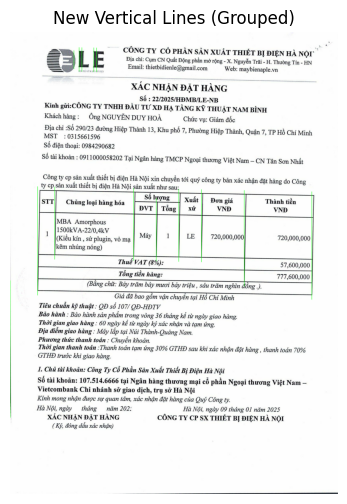

In [22]:
def group_v_lines(v_lines, thin_thresh):
    new_v_lines = []
    while len(v_lines) > 0:
        thresh = sorted(v_lines, key=lambda x: x[0][0])[0][0]
        lines = [line for line in v_lines if thresh[0] -
                 thin_thresh <= line[0][0] <= thresh[0] + thin_thresh]
        v_lines = [line for line in v_lines if thresh[0] - thin_thresh >
                   line[0][0] or line[0][0] > thresh[0] + thin_thresh]
        y = []
        for line in lines:
            y.append(line[0][1])
            y.append(line[0][3])
        # Adjust the padding factor to be smaller (from 4 to 1.5)
        y_min, y_max = min(y) - int(1.5*thin_thresh), max(y) + int(1.5*thin_thresh)
        new_v_lines.append([thresh[0], y_min, thresh[0], y_max])
    return new_v_lines
    
new_vertical_lines = group_v_lines(v_lines, kernel_len)

img_with_v = processed_img.copy()

for line in new_vertical_lines:
    x1, y1, x2, y2 = line
    cv2.line(img_with_v, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(img_with_v, cv2.COLOR_BGR2RGB))
plt.title("New Vertical Lines (Grouped)")
plt.axis("off")
plt.show()

In [23]:
def seg_intersect(line1: list, line2: list):
    a1, a2 = line1
    b1, b2 = line2
    da = a2-a1
    db = b2-b1
    dp = a1-b1

    def perp(a):
        b = np.empty_like(a)
        b[0] = -a[1]
        b[1] = a[0]
        return b

    dap = perp(da)
    denom = np.dot(dap, db)
    num = np.dot(dap, dp)
    return (num / denom.astype(float))*db + b1


In [24]:
# Nếu chưa có thì đừng chạy tiếp, tránh lỗi
print(len(new_horizontal_lines), len(new_vertical_lines))

19 14


In [25]:
points = []
for hline in new_horizontal_lines:
    x1A, y1A, x2A, y2A = hline
    for vline in new_vertical_lines:
        x1B, y1B, x2B, y2B = vline

        line1 = [np.array([x1A, y1A]), np.array([x2A, y2A])]
        line2 = [np.array([x1B, y1B]), np.array([x2B, y2B])]

        x, y = seg_intersect(line1, line2)
        if x1A <= x <= x2A and y1B <= y <= y2B:
            points.append([int(x), int(y)])


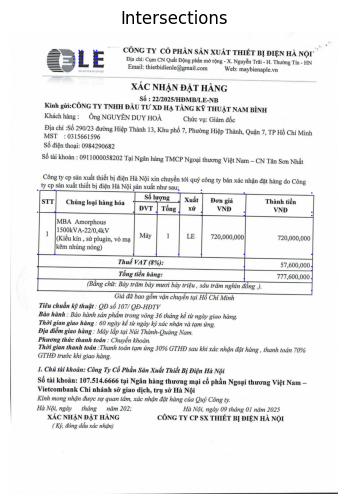

In [26]:
img_points = processed_img.copy()

for x, y in points:
    cv2.circle(img_points, (x, y), 5, (255, 0, 0), -1)

plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(img_points, cv2.COLOR_BGR2RGB))
plt.title("Intersections")
plt.axis("off")
plt.show()

In [27]:
table_img_copy = processed_img.copy()  # hoặc ảnh gốc đã xử lý bảng

In [28]:
def get_bottom_right(right_points, bottom_points, points):
    for right in right_points:
        for bottom in bottom_points:
            if [right[0], bottom[1]] in points:
                return right[0], bottom[1]
    return None, None

cells = []
for point in points:
    left, top = point
    right_points = sorted(
        [p for p in points if p[0] > left and p[1] == top], key=lambda x: x[0])
    bottom_points = sorted(
        [p for p in points if p[1] > top and p[0] == left], key=lambda x: x[1])

    right, bottom = get_bottom_right(
        right_points, bottom_points, points)
    if right and bottom:
        cv2.rectangle(table_img_copy, (left, top), (right, bottom), (0, 0, 255), 2)
        cells.append([left, top, right, bottom])


In [29]:
def filter_cells(cells, min_width=20, min_height=10, area_threshold=0.5):
    """Filter out invalid cells that are too small or have unusual dimensions"""
    filtered_cells = []
    
    # Compute average cell dimensions
    widths = [cell[2] - cell[0] for cell in cells]
    heights = [cell[3] - cell[1] for cell in cells]
    avg_width = sum(widths) / len(widths) if widths else 0
    avg_height = sum(heights) / len(heights) if heights else 0
    
    # Filter cells
    for cell in cells:
        width = cell[2] - cell[0]
        height = cell[3] - cell[1]
        area = width * height
        avg_area = avg_width * avg_height
        
        if (width >= min_width and height >= min_height and 
            area >= area_threshold * avg_area):
            filtered_cells.append(cell)
            
    return filtered_cells

def get_bottom_right(right_points, bottom_points, points):
    for right in right_points:
        for bottom in bottom_points:
            if [right[0], bottom[1]] in points:
                return right[0], bottom[1]
    return None, None

cells = []
for point in points:
    left, top = point
    right_points = sorted(
        [p for p in points if p[0] > left and p[1] == top], key=lambda x: x[0])
    bottom_points = sorted(
        [p for p in points if p[1] > top and p[0] == left], key=lambda x: x[1])

    right, bottom = get_bottom_right(
        right_points, bottom_points, points)
    if right and bottom:
        cv2.rectangle(table_img_copy, (left, top), (right, bottom), (0, 0, 255), 2)
        cells.append([left, top, right, bottom])

# Filter small or invalid cells
filtered_cells = filter_cells(cells)
print(f"Detected {len(cells)} cells, kept {len(filtered_cells)} after filtering")

# Update the display with filtered cells
table_img_filtered = deskewed_img.copy()
for left, top, right, bottom in filtered_cells:
    cv2.rectangle(table_img_filtered, (left, top), (right, bottom), (0, 0, 255), 2)

Detected 42 cells, kept 18 after filtering


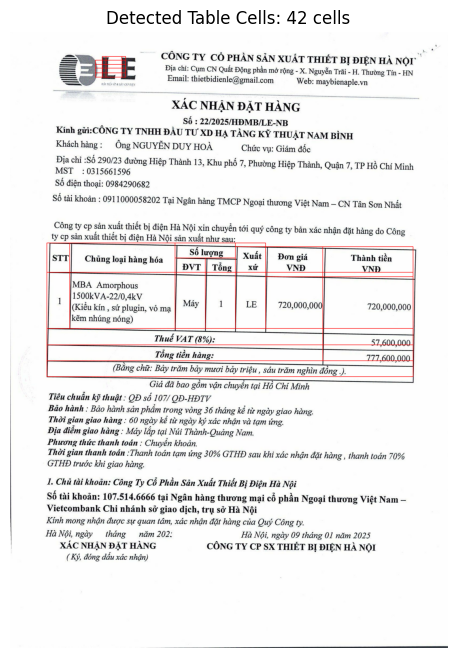

In [30]:
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(table_img_copy, cv2.COLOR_BGR2RGB))
plt.title(f"Detected Table Cells: {len(cells)} cells")
plt.axis("off")
plt.show()

/Users/buidokhoinguyen/Desktop/PDFMiner-microservice/document-process-service/venv/lib/python3.9/site-packages/paddle/utils/cpp_extension/extension_utils.py:711: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)


[2025/05/18 09:22:54] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/Users/buidokhoinguyen/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/Users/buidokhoinguyen/.paddleocr/whl/rec/latin/latin_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_l

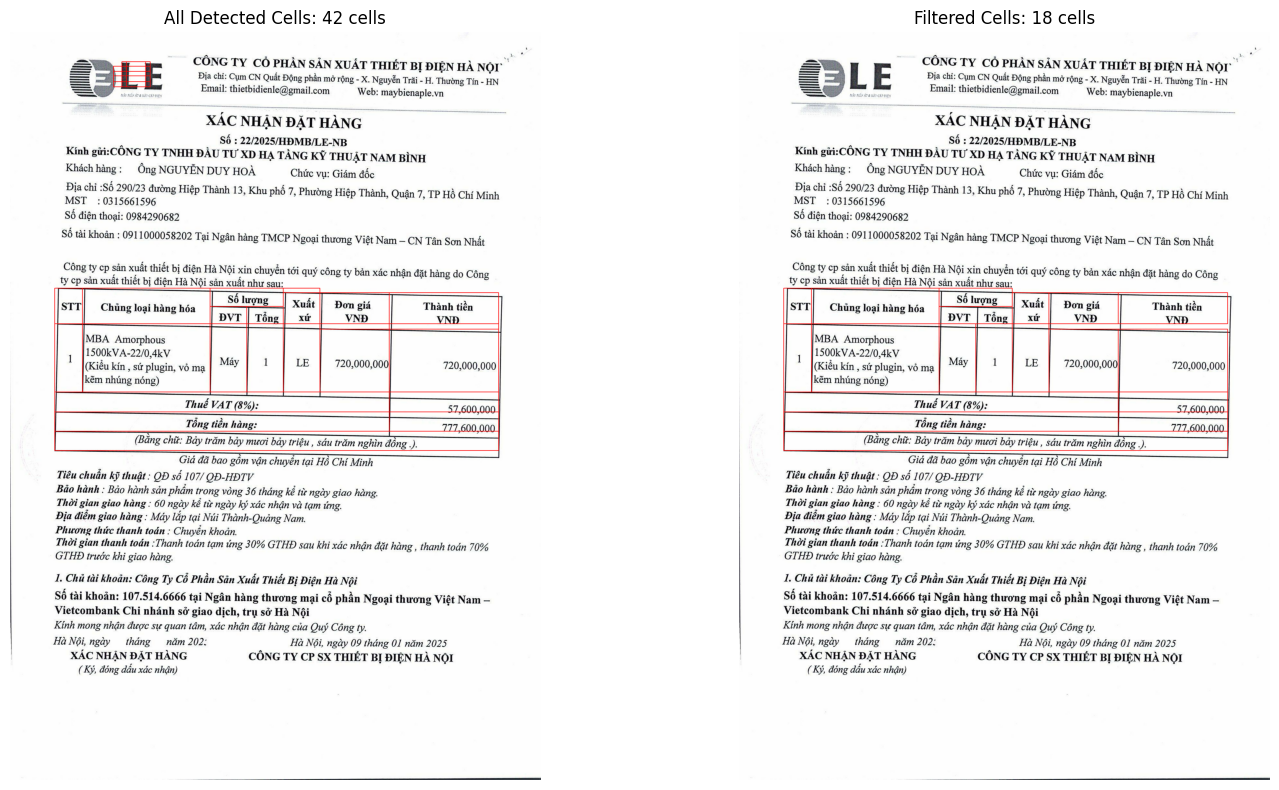

In [31]:
from PaddleOCR import PaddleOCR, draw_ocr
detector = PaddleOCR(use_angle_cls=False, lang="vi", use_gpu=False)

# Display results side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# All detected cells
axes[0].imshow(cv2.cvtColor(table_img_copy, cv2.COLOR_BGR2RGB))
axes[0].set_title(f"All Detected Cells: {len(cells)} cells")
axes[0].axis("off")

# Filtered cells 
axes[1].imshow(cv2.cvtColor(table_img_filtered, cv2.COLOR_BGR2RGB))
axes[1].set_title(f"Filtered Cells: {len(filtered_cells)} cells")
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [32]:
# Extract text from each cell
def extract_text_from_cell(img, cell, detector):
    x1, y1, x2, y2 = cell
    # Add a small padding to avoid cutting off text
    padding = 2
    cell_img = img[max(0, y1-padding):min(img.shape[0], y2+padding), 
                 max(0, x1-padding):min(img.shape[1], x2+padding)]
    
    # Run OCR on the cell image
    result = detector.ocr(cell_img, cls=False)
    
    # Extract text from result
    if result and result[0]:
        texts = [line[1][0] for line in result[0]]
        return ' '.join(texts)
    return ''

# Create a structured representation of the table
def create_table_structure(img, cells, detector):
    # Sort cells by their y-coordinate (row) and then by x-coordinate (column)
    # First, group cells by similar y values (rows)
    y_values = [cell[1] for cell in cells]
    y_values.sort()
    
    # Determine row boundaries
    row_boundaries = []
    if y_values:
        current_row = y_values[0]
        row_boundaries.append(current_row)
        
        for y in y_values[1:]:
            if abs(y - current_row) > 10:  # threshold to determine new row
                current_row = y
                row_boundaries.append(current_row)
    
    # Group cells into rows
    rows = [[] for _ in range(len(row_boundaries))]
    for cell in cells:
        row_idx = min(range(len(row_boundaries)), 
                     key=lambda i: abs(cell[1] - row_boundaries[i]))
        rows[row_idx].append(cell)
    
    # Sort each row by x-coordinate
    for i in range(len(rows)):
        rows[i].sort(key=lambda cell: cell[0])
    
    # Extract text from each cell
    table_data = []
    for row in rows:
        row_data = []
        for cell in row:
            text = extract_text_from_cell(img, cell, detector)
            row_data.append(text)
        table_data.append(row_data)
    
    return table_data

# If detector is available, we can extract the table content
try:
    # Extract text from the filtered cells
    table_data = create_table_structure(deskewed_img, filtered_cells, detector)
    
    # Print the structured table
    print("\nExtracted Table Content:")
    for row in table_data:
        print(row)
        
    # Create a visualization with text
    cell_text_img = deskewed_img.copy()
    for i, row in enumerate(rows):
        for j, cell in enumerate(row):
            x1, y1, x2, y2 = cell
            text = table_data[i][j]
            cv2.putText(cell_text_img, text[:20], 
                      (x1+5, y1+20), cv2.FONT_HERSHEY_SIMPLEX, 
                      0.5, (0, 0, 255), 1)
            
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(cell_text_img, cv2.COLOR_BGR2RGB))
    plt.title("Table with Extracted Text")
    plt.axis("off")
    plt.show()
    
except NameError as e:
    print(f"OCR detector not available or not initialized: {e}")

[2025/05/18 09:23:00] ppocr DEBUG: dt_boxes num : 1, elapse : 0.022631168365478516
[2025/05/18 09:23:00] ppocr DEBUG: rec_res num  : 1, elapse : 0.04088091850280762
[2025/05/18 09:23:00] ppocr DEBUG: dt_boxes num : 1, elapse : 0.03603315353393555
[2025/05/18 09:23:00] ppocr DEBUG: rec_res num  : 1, elapse : 0.053235769271850586
[2025/05/18 09:23:00] ppocr DEBUG: dt_boxes num : 1, elapse : 0.015354156494140625
[2025/05/18 09:23:01] ppocr DEBUG: rec_res num  : 1, elapse : 0.03976011276245117
[2025/05/18 09:23:01] ppocr DEBUG: dt_boxes num : 2, elapse : 0.014996767044067383


RuntimeError: (NotFound) No allocator found for the place, Place(undefined:0)
  [Hint: Expected iter != allocators.end(), but received iter == allocators.end().] (at /Users/paddle/xly/workspace/7b5bf7ed-f223-4c37-9311-a1c9d604457b/Paddle/paddle/phi/core/memory/allocation/allocator_facade.cc:381)
  [operator < matmul > error]